In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import torch
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
import string
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from models import main_cnn
from scikitplot.estimators import plot_learning_curve
import warnings

We provide the following dataset (ASSIGNMENT_2.csv):
    
| Composition title | Composition Writers | Recording Title | Recording Writes |Action |
| --- | --- |--- | --- |--- |
| Yellow submarine | Leo Ouha |Yellow submarine(remix) |Leo Ouha |Leo Ouha |ACCEPTED |
| Shape of you | Ed Sheeran| Anaconda | Mick George | Roco Selto |Leo REJECTED |


Train an ML/DL model for pair matching of compositions and recordings.
Report and evaluate the results.

In [2]:
warnings.filterwarnings("ignore")

In [3]:
input_dataset = pd.read_csv("dataset/ASSIGNMENT_2.csv")

In [4]:
input_dataset = input_dataset.drop_duplicates().dropna()

for col in list(input_dataset.columns):
    input_dataset.loc[:, col] = input_dataset.loc[:, col].apply(lambda x: x.lower())

print(input_dataset["Action"].str.lower().unique())

['rejected' 'accepted' 'no decision' 'no_decision']


In [5]:
input_dataset.loc[input_dataset["Action"] == 'no decision', "Action"] = "no_decision"

In [6]:
input_dataset = input_dataset.loc[input_dataset["Action"]!="no_decision", :]
# we drop the rows with "no decision" label since they don't offer us any information 
# wether we have a match or not.

In [7]:
labelizer = LabelEncoder()
lb_res = labelizer.fit_transform(input_dataset.loc[:, "Action"])

input_dataset.loc[:, "Action"]= lb_res
print(Counter(input_dataset["Action"]))

Counter({0: 1485, 1: 522})


In this kind of task we have to keep stopwords and punctuation it is important on these kind of texts (just like sentiment analysis)

For starters we need to create a baseline to beat. So we could do a first run with a simple logistic regression and
an XGBoost

In [8]:
input_dataset.head(2)

,Composition Title,Composition Writers,Recording Title,Recording Writers,Recording Artist,Action
0,kokaina,yassine baybah|daniel dlouhy,kokaina,a baybah c dlouhy,miami yacine,1
1,por estar contigo,"martinez escamilla,felipe de jesus",estar contigo,martinez de ubago rodriguez alejandro,"alex, jorge y lena",1


In order to run any kind of machine learning model, we need to transform the features into tf-idf vectors.

If we had more data i would've trained embeddings from the dataset.

In [9]:
feature_cols = list(input_dataset.loc[:, input_dataset.columns!="Action"].columns)

In [10]:
input_dataset.loc[:, feature_cols].describe()

,Composition Title,Composition Writers,Recording Title,Recording Writers,Recording Artist
count,2007,2007,2007,2007,2007
unique,1802,1835,1897,1812,1660
top,flower of scotland,roy murdoch buchanan williamson,flower of scotland,traditional,various artists
freq,9,9,9,13,9


We want to remove punctuation since we know that when we concatenate the dataset and make all the features into sentences.
The punctuation wont matter anymore. Since it is not important for our matching purposes

In [11]:
for col in input_dataset.columns:
    if col!="Action":
        input_dataset.loc[:, col] = input_dataset.loc[:, col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [12]:
vectorizer = TfidfVectorizer(analyzer='word')

input_dataset.loc[:, feature_cols[0]] =  input_dataset.loc[:, feature_cols[1:]].apply(lambda x: ",".join(x), axis=1)

input_dataset = pd.DataFrame(input_dataset.loc[:, feature_cols[0]])

Train test split and tf-idf vectorization 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(input_dataset, lb_res, shuffle=True, random_state=42, test_size=0.2)

X_train  = vectorizer.fit_transform(X_train.iloc[:,0])
X_test = vectorizer.transform(X_test.iloc[:, 0])

In [14]:
X_train = csr_matrix(X_train)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
X_train = svd.fit_transform(X_train)

X_test = csr_matrix(X_test)
X_test = svd.fit_transform(X_test)

In [15]:
X_train.shape

(1605, 100)

The application of SVD was important here since the sparsity of those matrices 
was substancial.

In [16]:
def get_results(ftt, f_test_t, y_tn, y_ts, classifier):
    print("value")
    # train the model
    classifier.fit(ftt, y_tn)
    print("classifier accuracy {:.2f}%".format(classifier.score(f_test_t, y_ts) * 100))
    # even though ACCURACY IS NOT A RELIABLE METRIC HERE we have to include it in our sets of metrics.
    labels = classifier.predict(f_test_t)
    actual = y_ts
    predicted = labels
    results = confusion_matrix(actual, predicted)
    print('Confusion Matrix :')
    print(results)
    print('Accuracy Score :', accuracy_score(actual, predicted))
    print('Report : ')
    print(classification_report(actual, predicted))
    score_2 = f1_score(actual, predicted, average='macro')
    print('F-Measure: %.3f' % score_2)
    return classifier

In order to proceed with more sofisticated solutions we need to enstablish a baseline first.

The linear Regression is a good start for that purpose

# Linear Regression 

In [17]:
lr = LogisticRegression(random_state=42)

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

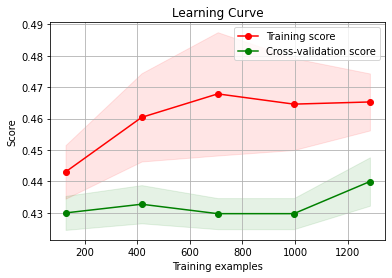

In [18]:
plot_learning_curve(lr, X=X_train, y=y_train, scoring='f1_macro')

In [19]:
get_results(X_train, X_test,y_train, y_test, lr)

value
classifier accuracy 70.65%
Confusion Matrix :
[[277   9]
 [109   7]]
Accuracy Score : 0.7064676616915423
Report : 
              precision    recall  f1-score   support

           0       0.72      0.97      0.82       286
           1       0.44      0.06      0.11       116

    accuracy                           0.71       402
   macro avg       0.58      0.51      0.47       402
weighted avg       0.64      0.71      0.62       402

F-Measure: 0.465


LogisticRegression(random_state=42)

# Random Forest Classifier #

In [20]:
rf = RandomForestClassifier(random_state=42)

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

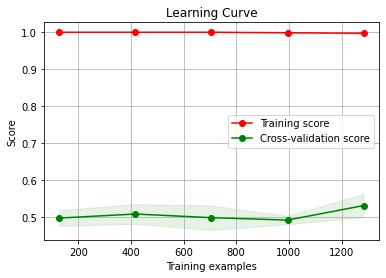

In [21]:
plot_learning_curve(rf, X_train, y_train, scoring='f1_macro')

In [22]:
get_results(X_train, X_test,y_train, y_test, rf)

value
classifier accuracy 66.42%
Confusion Matrix :
[[245  41]
 [ 94  22]]
Accuracy Score : 0.664179104477612
Report : 
              precision    recall  f1-score   support

           0       0.72      0.86      0.78       286
           1       0.35      0.19      0.25       116

    accuracy                           0.66       402
   macro avg       0.54      0.52      0.51       402
weighted avg       0.61      0.66      0.63       402

F-Measure: 0.515


RandomForestClassifier(random_state=42)

# XGBoost classfier

In [23]:
xgb = XGBClassifier(random_state=42, max_depth=7, min_child_weight=5, n_estimators=100, eval_metric="logloss")

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

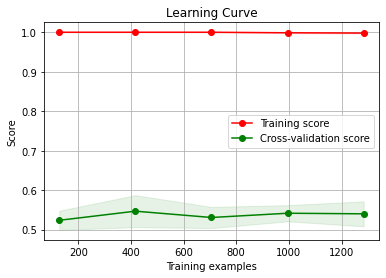

In [24]:
plot_learning_curve(xgb, X_train, y_train, scoring='f1_macro')

In [25]:
get_results(X_train, X_test,y_train, y_test, xgb)

value
classifier accuracy 64.93%
Confusion Matrix :
[[226  60]
 [ 81  35]]
Accuracy Score : 0.6492537313432836
Report : 
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       286
           1       0.37      0.30      0.33       116

    accuracy                           0.65       402
   macro avg       0.55      0.55      0.55       402
weighted avg       0.63      0.65      0.64       402

F-Measure: 0.547


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

# Multilayer Perceptron

In [26]:
mlp = MLPClassifier(random_state=42, activation='tanh', hidden_layer_sizes=(5, 150))

<AxesSubplot:title={'center':'(0.1, 1.01)'}, xlabel='Training examples', ylabel='Score'>

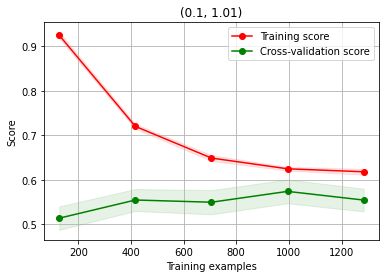

In [27]:
plot_learning_curve(mlp, X_train, y_train, (0.1, 1.01), n_jobs=-1, scoring='f1_macro')

In [28]:
get_results(X_train, X_test,y_train, y_test, mlp)

value
classifier accuracy 67.91%
Confusion Matrix :
[[243  43]
 [ 86  30]]
Accuracy Score : 0.6791044776119403
Report : 
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       286
           1       0.41      0.26      0.32       116

    accuracy                           0.68       402
   macro avg       0.57      0.55      0.55       402
weighted avg       0.64      0.68      0.65       402

F-Measure: 0.554


MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 150), random_state=42)

Given that we achieve low scores especially on the precision of class rejected (which makes sense because so far we have majority classifiers of class accepted).

# DNN approach 

We applied dimentionality reduction in the same manner as the previous models

In [29]:
train_scores, eval_scores, train_losses, eval_losses = main_cnn((input_dataset, lb_res))

/home/dlolis/Desktop/assignment/assignment_of/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dlolis/Desktop/assignment/assignment_of/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dlolis/Desktop/assignment/assignment_of/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dlolis/Desktop/assignment/assignment_of/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the 

best evaluation scores are on 0.4406059799378048 198
best model loss score is 0.5948562026023865 on 199 epoch


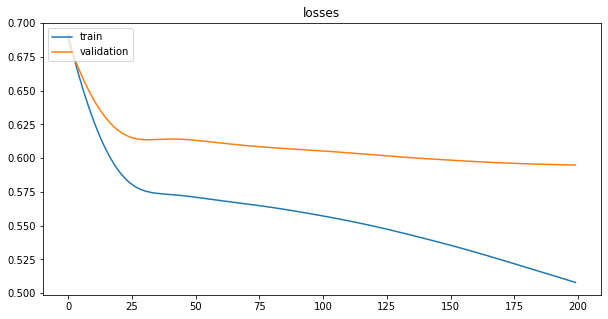

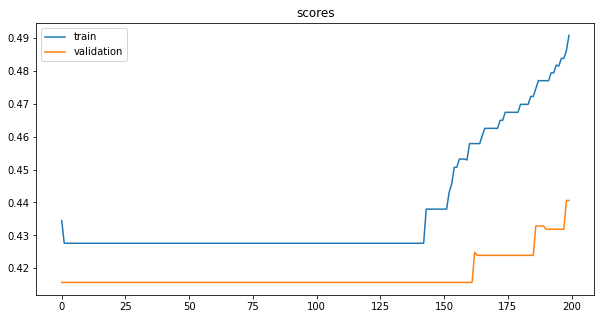

In [30]:
plt.figure(figsize=(10, 5))
plt.title("losses")
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="validation")
plt.legend(loc="upper left")

plt.show()

plt.figure(figsize=(10, 5))
plt.title("scores")
plt.plot(train_scores, label="train")
plt.plot(eval_scores, label="validation")
plt.legend(loc="upper left")

plt.show()

# Conclusions

### Traditional Algorithms with tf-idf approach ###


The *traditional* machine learning algorithms that were used on this assignment (logistic regression, random forest, XGBoost classifier, MLP), as the curves of the models suggest (increasing training size, minuscule increase of score) the models cannot interpret the features in meaningfull manner (even though it should). 


### The CNN approach with tf-idf ###


In such a small dataset a DNN couldn't possibly outperform a traditional machine learning approach. But in order to have the complete picture of the solution for this problem i had to create and tune it.

### Custom features needed ###

In order to get more meaningful results it is of paramount importance to change our features to be able to recognize matches (even with aliases) in Composition and Recording. In this task it would be probably important to get domain knowledge and create artificial input that will be a function of our original such as handcrafted features.

## Possible next step ##

#### One Shot Learning ####

In this assignment i concatenated all of the fields and created one sentence that contained all of the information needed. Another way this problem could be done is to create two vectors (one for Composition one for Recording) and create Siamese neural networks to compare them. This would require of course more data and an embedding representation of our data, since tf-idf and SVD approach do not seem enough to "capture" the essence of our data input.
